In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
# os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb, auto_call_seq_ctx_nb
from vectorbt.portfolio.enums import SizeType, Direction

In [2]:
# Define params
assets = ['FB', 'AMZN', 'NFLX', 'GOOG', 'AAPL']
start_date = datetime(2017, 1, 1)
end_date = datetime.now()
num_tests = 2000

vbt.settings.returns['year_freq'] = '252 days'

In [3]:
# Download data
asset_price = pd.DataFrame({
    s: yf.Ticker(s).history(start=start_date, end=end_date)['Close'] 
    for s in assets
}, columns=pd.Index(assets, name='asset'))

print(asset_price.shape)

(1010, 5)


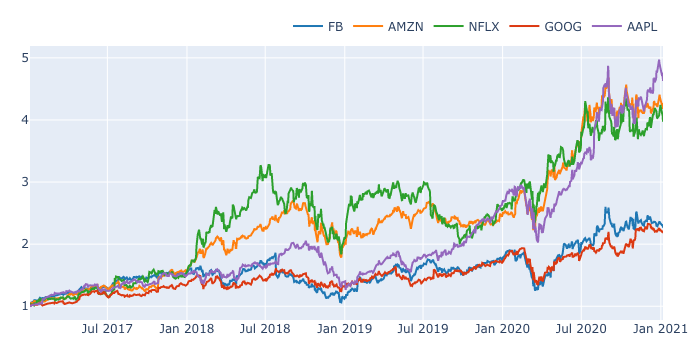

In [4]:
# Plot normalized price series
(asset_price / asset_price.iloc[0]).vbt.scatter().show_png()

In [5]:
asset_returns = asset_price.pct_change()

In [6]:
print(asset_returns.mean())

asset
FB      0.001043
AMZN    0.001603
NFLX    0.001677
GOOG    0.000934
AAPL    0.001718
dtype: float64


In [7]:
print(asset_returns.std())

asset
FB      0.021419
AMZN    0.019290
NFLX    0.024919
GOOG    0.017463
AAPL    0.019956
dtype: float64


In [8]:
print(asset_returns.corr())

asset        FB      AMZN      NFLX      GOOG      AAPL
asset                                                  
FB     1.000000  0.632301  0.505737  0.701906  0.616443
AMZN   0.632301  1.000000  0.638220  0.682786  0.641479
NFLX   0.505737  0.638220  1.000000  0.539280  0.491442
GOOG   0.701906  0.682786  0.539280  1.000000  0.679344
AAPL   0.616443  0.641479  0.491442  0.679344  1.000000


## vectorbt: Random search

### One-time allocation

In [9]:
np.random.seed(42)

# Generate random weights, n times
weights = []
for i in range(num_tests):
    w = np.random.random_sample(len(assets))
    w = w / np.sum(w)
    weights.append(w)

print(len(weights))

2000


In [10]:
# Build column hierarchy such that one weight corresponds to one price series
_asset_price = asset_price.vbt.tile(num_tests, keys=pd.Index(np.arange(num_tests), name='asset_group'))
_asset_price = _asset_price.vbt.stack_index(pd.Index(np.concatenate(weights), name='weights'))

print(_asset_price.columns)

MultiIndex([( 0.13319702814025883,    0,   'FB'),
            ( 0.33810081711389406,    0, 'AMZN'),
            ( 0.26031768763785473,    0, 'NFLX'),
            (  0.2128998389048247,    0, 'GOOG'),
            ( 0.05548462820316767,    0, 'AAPL'),
            ( 0.06528491964469331,    1,   'FB'),
            ( 0.02430844330237927,    1, 'AMZN'),
            (  0.3625014516740258,    1, 'NFLX'),
            (  0.2515713061862386,    1, 'GOOG'),
            ( 0.29633387919266296,    1, 'AAPL'),
            ...
            (  0.2056564359049325, 1998,   'FB'),
            ( 0.14846396871443943, 1998, 'AMZN'),
            ( 0.21512097636364197, 1998, 'NFLX'),
            (  0.3738566007394396, 1998, 'GOOG'),
            (0.056902018277546554, 1998, 'AAPL'),
            ( 0.25860265182212094, 1999,   'FB'),
            (  0.2706191852849979, 1999, 'AMZN'),
            (  0.2854538191129893, 1999, 'NFLX'),
            ( 0.11985160754099378, 1999, 'GOOG'),
            (  0.0654727362388982,

In [11]:
# Define order size
size = np.full_like(_asset_price, np.nan)
size[0, :] = np.concatenate(weights)  # allocate at first timestamp, do nothing afterwards

print(size.shape)

(1010, 10000)


**NOTE:** Do not attempt to run the following simulation with Numba disabled.

In [12]:
%%time
# Run simulation
portfolio = vbt.Portfolio.from_orders(
    close=_asset_price,
    size=size,
    size_type='targetpercent',
    group_by='asset_group',
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
) # all weights sum to 1, no shorting, and 100% investment in risky assets

print(len(portfolio.orders))

10000
CPU times: user 2.29 s, sys: 101 ms, total: 2.39 s
Wall time: 2.62 s


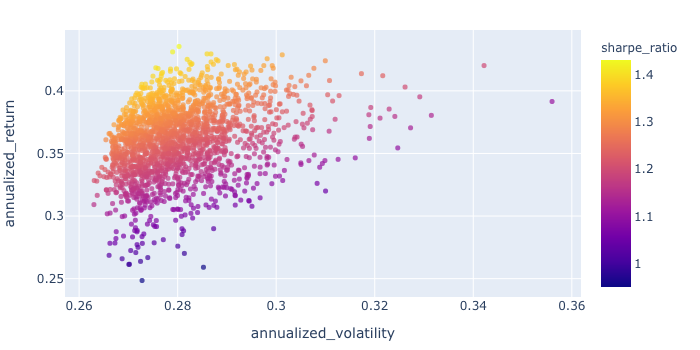

In [13]:
# Plot annualized return against volatility, color by sharpe ratio
annualized_return = portfolio.annualized_return()
annualized_return.index = portfolio.annualized_volatility()
annualized_return.vbt.scatter(
    trace_kwargs=dict(
        mode='markers', 
        marker=dict(
            color=portfolio.sharpe_ratio(),
            colorbar=dict(
                title='sharpe_ratio'
            ),
            size=5,
            opacity=0.7
        )
    ),
    xaxis_title='annualized_volatility',
    yaxis_title='annualized_return'
).show_png()

In [14]:
# Get index of the best group according to the target metric
best_asset_group = portfolio.sharpe_ratio().idxmax()

print(best_asset_group)

1920


In [15]:
# Print best weights
print(weights[best_asset_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [16]:
# Compute default stats
print(portfolio.iloc[best_asset_group].stats())

Start                            2017-01-03 00:00:00
End                              2021-01-06 00:00:00
Duration                          1010 days 00:00:00
Init. Cash                                       100
Total Profit                                 325.782
Total Return [%]                             325.782
Benchmark Return [%]                          244.76
Position Coverage [%]                            100
Max. Drawdown [%]                            34.4419
Avg. Drawdown [%]                            2.89982
Max. Drawdown Duration             324 days 00:00:00
Avg. Drawdown Duration    13 days 02:49:24.705882353
Num. Trades                                        5
Win Rate [%]                                     100
Best Trade [%]                               362.602
Worst Trade [%]                              119.969
Avg. Trade [%]                                244.76
Max. Trade Duration               1009 days 00:00:00
Avg. Trade Duration               1009 days 00

### Rebalance monthly

In [17]:
# Select the first index of each month
rb_mask = ~_asset_price.index.to_period('m').duplicated()

print(rb_mask.sum())

49


In [18]:
rb_size = np.full_like(_asset_price, np.nan)
rb_size[rb_mask, :] = np.concatenate(weights)  # allocate at mask

print(rb_size.shape)

(1010, 10000)


**NOTE:** Do not attempt to run the following simulation with Numba disabled.

In [19]:
%%time

# Run simulation, with rebalancing monthly
rb_portfolio = vbt.Portfolio.from_orders(
    close=_asset_price,
    size=rb_size,
    size_type='targetpercent',
    group_by='asset_group',
    cash_sharing=True,
    call_seq='auto',  # important: sell before buy
    freq='D',
    incl_unrealized=True
)

print(len(rb_portfolio.orders))

489993
CPU times: user 536 ms, sys: 48.9 ms, total: 584 ms
Wall time: 645 ms


In [20]:
rb_best_asset_group = portfolio.sharpe_ratio().idxmax()

print(rb_best_asset_group)

1920


In [21]:
print(weights[rb_best_asset_group])

[0.01154842 0.46529877 0.10296527 0.02644507 0.39374246]


In [22]:
print(rb_portfolio.iloc[rb_best_asset_group].stats())

Start                            2017-01-03 00:00:00
End                              2021-01-06 00:00:00
Duration                          1010 days 00:00:00
Init. Cash                                       100
Total Profit                                 342.995
Total Return [%]                             342.995
Benchmark Return [%]                          244.76
Position Coverage [%]                            100
Max. Drawdown [%]                            33.6883
Avg. Drawdown [%]                            2.79293
Max. Drawdown Duration             304 days 00:00:00
Avg. Drawdown Duration    12 days 03:56:42.739726027
Num. Trades                                      112
Win Rate [%]                                 99.1071
Best Trade [%]                               249.175
Worst Trade [%]                             -7.13426
Avg. Trade [%]                               64.4569
Max. Trade Duration               1009 days 00:00:00
Avg. Trade Duration                523 days 01

In [23]:
def plot_allocation(rb_portfolio):
    # Plot weights development of the portfolio
    rb_holding_value = rb_portfolio.holding_value(group_by=False)
    rb_value = rb_portfolio.value()
    rb_idxs = np.flatnonzero((rb_portfolio.share_flow() != 0).any(axis=1))
    (rb_holding_value.vbt / rb_value).vbt.scatter(
        trace_names=assets,
        trace_kwargs=dict(
            stackgroup='one'
        ),
        shapes=[dict(
            xref='x',
            yref='paper',
            x0=date,
            x1=date,
            y0=0,
            y1=1,
            line_color=vbt.settings.layout['template']['layout']['plot_bgcolor']
        ) for date in asset_price.index[rb_idxs]]
    ).show_png()

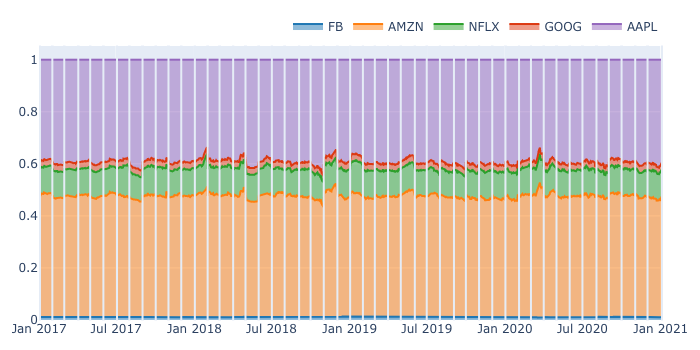

In [24]:
plot_allocation(rb_portfolio.iloc[rb_best_asset_group])  # best group

### Search and rebalance every 30 days

Utilize low-level API to dynamically search for best Sharpe ratio and rebalance accordingly. Compared to previous method, we won't utilize stacking, but do search in a loop instead. We also will use days instead of months, as latter may contain a various number of trading days.

In [25]:
srb_sharpe = np.full(asset_price.shape[0], np.nan)

@njit
def prep_func_nb(simc, every_nth):
    # Define rebalancing days
    simc.active_mask[:, :] = False
    simc.active_mask[every_nth::every_nth, :] = True
    return ()

@njit
def find_weights_nb(sc, close, num_tests):
    # Find optimal weights based on best Sharpe ratio
    returns = (close[1:] - close[:-1]) / close[:-1]
    returns = returns[1:, :]  # cannot compute np.cov with NaN
    mean = nanmean_nb(returns)
    cov = np.cov(returns, rowvar=False)  # masked arrays not supported by Numba (yet)
    best_sharpe_ratio = -np.inf
    
    for i in range(num_tests):
        # Generate weights
        w = np.random.random_sample(sc.group_len)
        w = w / np.sum(w)
        
        # Compute annualized mean, covariance, and Sharpe ratio
        p_return = np.sum(mean * w) * ann_factor
        p_std = np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(ann_factor)
        sharpe_ratio = p_return / p_std
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            weights = w
            
    return best_sharpe_ratio, weights

@njit
def segment_prep_func_nb(sc, find_weights_nb, history_len, ann_factor, num_tests, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = sc.close[:sc.i, sc.from_col:sc.to_col]
    else:
        # Look back at a fixed time period
        if sc.i - history_len <= 0:
            return (np.full(sc.group_len, np.nan),)  # insufficient data
        close = sc.close[sc.i - history_len:sc.i, sc.from_col:sc.to_col]
    
    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(sc, close, num_tests)
    srb_sharpe[sc.i] = best_sharpe_ratio
        
    # Update valuation price and reorder orders
    size_type = np.full(sc.group_len, SizeType.TargetPercent)
    direction = np.full(sc.group_len, Direction.LongOnly)
    temp_float_arr = np.empty(sc.group_len, dtype=np.float_)
    for k in range(sc.group_len):
        col = sc.from_col + k
        sc.last_val_price[col] = sc.close[sc.i, col]
    auto_call_seq_ctx_nb(sc, weights, size_type, direction, temp_float_arr)
    
    return (weights,)

@njit
def order_func_nb(oc, weights):
    col_i = oc.call_seq_now[oc.call_idx]
    return create_order_nb(
        size=weights[col_i], 
        size_type=SizeType.TargetPercent, 
        price=oc.close[oc.i, oc.col]
    )

In [26]:
%%time
# Run simulation using a custom order function
ann_factor = asset_returns.vbt.returns(freq='D').ann_factor
srb_portfolio = vbt.Portfolio.from_order_func(
    asset_price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, -1, ann_factor, num_tests, srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 9.7 s, sys: 120 ms, total: 9.82 s
Wall time: 9.91 s


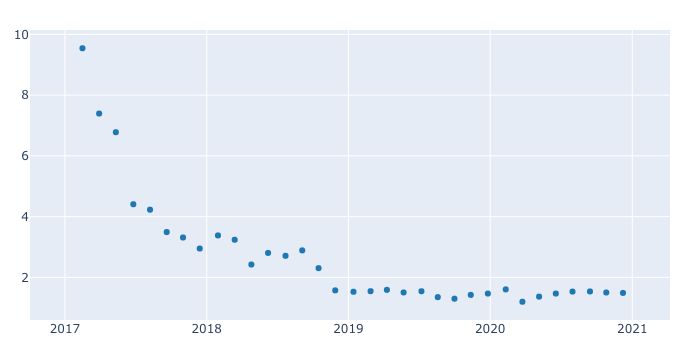

In [27]:
# Plot best Sharpe ratio at each rebalancing day
pd.Series(srb_sharpe, index=asset_price.index).vbt.scatter(trace_kwargs=dict(mode='markers')).show_png()

In [28]:
print(srb_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-01-06 00:00:00
Duration                           1010 days 00:00:00
Init. Cash                                        100
Total Profit                                   191.25
Total Return [%]                               191.25
Benchmark Return [%]                           244.76
Position Coverage [%]                         97.0297
Max. Drawdown [%]                             34.3509
Avg. Drawdown [%]                             3.26327
Max. Drawdown Duration              311 days 00:00:00
Avg. Drawdown Duration               15 days 03:12:00
Num. Trades                                        89
Win Rate [%]                                  79.7753
Best Trade [%]                                 69.417
Worst Trade [%]                              -23.7438
Avg. Trade [%]                                 13.097
Max. Trade Duration                 979 days 00:00:00
Avg. Trade Duration       51

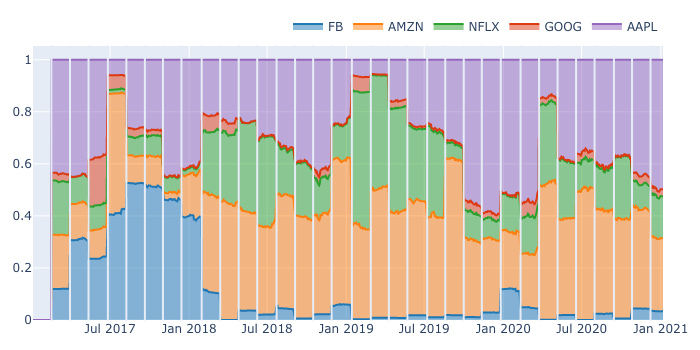

In [29]:
plot_allocation(srb_portfolio)

You can see how weights stabilize themselves with growing data.

In [30]:
%%time
# Run simulation, but now consider only the last 252 days of data
srb252_sharpe = np.full(asset_price.shape[0], np.nan)

srb252_portfolio = vbt.Portfolio.from_order_func(
    asset_price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(find_weights_nb, 252, ann_factor, num_tests, srb252_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 57.8 ms, sys: 1.74 ms, total: 59.5 ms
Wall time: 69.4 ms


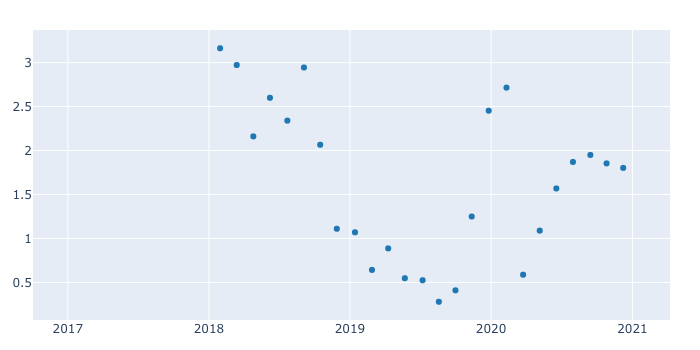

In [31]:
pd.Series(srb252_sharpe, index=asset_price.index).vbt.scatter(trace_kwargs=dict(mode='markers')).show_png()

In [32]:
print(srb252_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2021-01-06 00:00:00
Duration                           1010 days 00:00:00
Init. Cash                                        100
Total Profit                                   112.98
Total Return [%]                               112.98
Benchmark Return [%]                           244.76
Position Coverage [%]                         73.2673
Max. Drawdown [%]                              33.136
Avg. Drawdown [%]                             4.21234
Max. Drawdown Duration              193 days 00:00:00
Avg. Drawdown Duration     16 days 05:01:23.720930232
Num. Trades                                        58
Win Rate [%]                                  70.6897
Best Trade [%]                                72.9851
Worst Trade [%]                              -15.5016
Avg. Trade [%]                                 9.2356
Max. Trade Duration                 739 days 00:00:00
Avg. Trade Duration       42

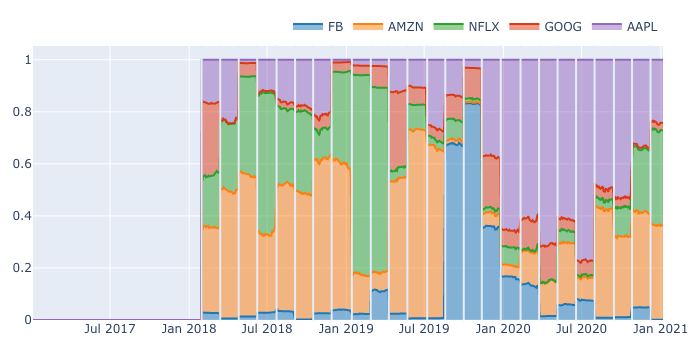

In [33]:
plot_allocation(srb252_portfolio)

A much more volatile weight distribution.

## PyPortfolioOpt + vectorbt

### One-time allocation

In [34]:
# Calculate expected returns and sample covariance amtrix
avg_returns = expected_returns.mean_historical_return(asset_price)
cov_mat = risk_models.sample_cov(asset_price)

# Get weights maximizing the Sharpe ratio
ef = EfficientFrontier(avg_returns, cov_mat)
weights = ef.max_sharpe()
clean_weights = ef.clean_weights()
pyopt_weights = np.array([clean_weights[asset] for asset in assets])

print(pyopt_weights)

[0.      0.41152 0.04816 0.      0.54032]


In [35]:
pyopt_size = np.full_like(asset_price, np.nan)
pyopt_size[0, :] = pyopt_weights  # allocate at first timestamp, do nothing afterwards

print(pyopt_size.shape)

(1010, 5)


In [36]:
%%time
# Run simulation with weights from PyPortfolioOpt
pyopt_portfolio = vbt.Portfolio.from_orders(
    close=asset_price,
    size=pyopt_size,
    size_type='targetpercent',
    group_by=True,
    cash_sharing=True,
    freq='D',
    incl_unrealized=True
)

print(len(pyopt_portfolio.orders))

3
CPU times: user 1.62 s, sys: 15.9 ms, total: 1.63 s
Wall time: 1.68 s


Faster than stacking solution, but doesn't let you compare weights.

In [37]:
print(pyopt_portfolio.stats())

Start                            2017-01-03 00:00:00
End                              2021-01-06 00:00:00
Duration                          1010 days 00:00:00
Init. Cash                                       100
Total Profit                                 340.933
Total Return [%]                             340.933
Benchmark Return [%]                          244.76
Position Coverage [%]                             60
Max. Drawdown [%]                            34.8364
Avg. Drawdown [%]                            2.59673
Max. Drawdown Duration             294 days 00:00:00
Avg. Drawdown Duration    11 days 09:25:03.797468354
Num. Trades                                        3
Win Rate [%]                                     100
Best Trade [%]                               362.602
Worst Trade [%]                              297.145
Avg. Trade [%]                               325.784
Max. Trade Duration               1009 days 00:00:00
Avg. Trade Duration               1009 days 00

### Search and rebalance monthly

**NOTE:** PyPortfolioOpt cannot run within Numba, so restart the notebook and disable Numba in the first cell.

In [34]:
def pyopt_find_weights(sc, close, num_tests):
    # Calculate expected returns and sample covariance matrix
    close = pd.DataFrame(close, columns=assets)
    avg_returns = expected_returns.mean_historical_return(close)
    cov_mat = risk_models.sample_cov(close)

    # Get weights maximizing the Sharpe ratio
    ef = EfficientFrontier(avg_returns, cov_mat)
    weights = ef.max_sharpe()
    clean_weights = ef.clean_weights()
    weights = np.array([clean_weights[asset] for asset in assets])
    best_sharpe_ratio = base_optimizer.portfolio_performance(weights, avg_returns, cov_mat)[2]
            
    return best_sharpe_ratio, weights

In [29]:
%%time
pyopt_srb_sharpe = np.full(asset_price.shape[0], np.nan)

# Run simulation with a custom order function (Numba should be disabled)
pyopt_srb_portfolio = vbt.Portfolio.from_order_func(
    asset_price,
    order_func_nb,
    prep_func_nb=prep_func_nb,
    prep_args=(30,),
    segment_prep_func_nb=segment_prep_func_nb,
    segment_prep_args=(pyopt_find_weights, -1, ann_factor, num_tests, pyopt_srb_sharpe),
    cash_sharing=True, 
    group_by=True,
    freq='D',
    incl_unrealized=True,
    seed=42
)

CPU times: user 672 ms, sys: 9.92 ms, total: 682 ms
Wall time: 714 ms


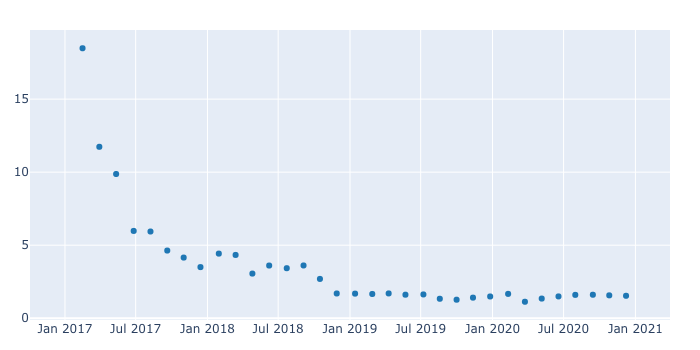

In [30]:
pd.Series(pyopt_srb_sharpe, index=asset_price.index).vbt.scatter(trace_kwargs=dict(mode='markers')).show_png()

In [31]:
print(pyopt_srb_portfolio.stats())

Start                             2017-01-03 00:00:00
End                               2020-12-29 00:00:00
Duration                           1005 days 00:00:00
Init. Cash                                        100
Total Profit                                  182.349
Total Return [%]                              182.349
Benchmark Return [%]                          263.919
Position Coverage [%]                         57.6119
Max. Drawdown [%]                             35.3639
Avg. Drawdown [%]                             3.59292
Max. Drawdown Duration              348 days 00:00:00
Avg. Drawdown Duration     16 days 16:08:43.636363636
Num. Trades                                        57
Win Rate [%]                                  84.2105
Best Trade [%]                                 67.983
Worst Trade [%]                              -30.6354
Avg. Trade [%]                                16.5467
Max. Trade Duration                 764 days 00:00:00
Avg. Trade Duration       23

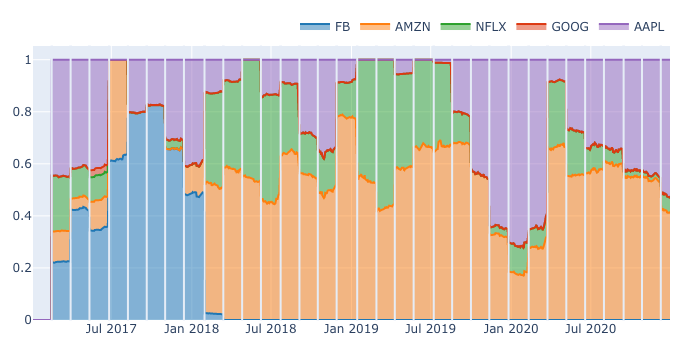

In [32]:
plot_allocation(pyopt_srb_portfolio)